In [2]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl

import libpysal.weights as sw
from pysal.explore.esda import Moran, Moran_Local
import spreg
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap, shift_colormap

In [3]:
# Read in the shapefile which has information of permanent forest loss, population density, and landcover
pop = gp.read_file('D:\\788P\\NLCD2006\\Pop05NLCD06LC04.shp')
pop

,FID_1,PopDen,index_righ,ForestLoss,Count_,Min_raster,geometry
0,0,7.075901,0.0,0.0,26,41.0,"POLYGON ((117829.516 4406753.945, 118219.516 4..."
1,1,6.186978,0.0,0.0,10,41.0,"POLYGON ((117139.516 4406783.945, 117589.516 4..."
2,2,11.784114,0.0,0.0,4,41.0,"POLYGON ((116419.516 4406813.945, 116989.516 4..."
3,3,9.279783,0.0,0.0,24,41.0,"POLYGON ((119269.516 4406693.945, 119449.516 4..."
4,4,10.927161,0.0,0.0,22,21.0,"POLYGON ((118549.516 4406723.945, 118819.516 4..."
...,...,...,...,...,...,...,...
43775,43775,0.000000,0.0,0.0,366,11.0,"POLYGON ((407779.516 4202663.945, 408229.516 4..."
43776,43776,2.138899,0.0,0.0,35,11.0,"POLYGON ((425299.516 4198793.945, 426049.516 4..."
43777,43777,2.081310,0.0,0.0,19,11.0,"POLYGON ((426049.516 4198793.945, 426679.516 4..."
43778,43778,0.000000,0.0,0.0,580,11.0,"POLYGON ((421669.516 4200653.945, 423859.516 4..."


In [5]:
# Clean the data
pop = pop.drop(columns=['index_righ', 'Count_'])
pop = pop.rename(columns={'Min_raster': 'LandCover'})
pop

,FID_1,PopDen,ForestLoss,LandCover,geometry
0,0,7.075901,0.0,41.0,"POLYGON ((117829.516 4406753.945, 118219.516 4..."
1,1,6.186978,0.0,41.0,"POLYGON ((117139.516 4406783.945, 117589.516 4..."
2,2,11.784114,0.0,41.0,"POLYGON ((116419.516 4406813.945, 116989.516 4..."
3,3,9.279783,0.0,41.0,"POLYGON ((119269.516 4406693.945, 119449.516 4..."
4,4,10.927161,0.0,21.0,"POLYGON ((118549.516 4406723.945, 118819.516 4..."
...,...,...,...,...,...
43775,43775,0.000000,0.0,11.0,"POLYGON ((407779.516 4202663.945, 408229.516 4..."
43776,43776,2.138899,0.0,11.0,"POLYGON ((425299.516 4198793.945, 426049.516 4..."
43777,43777,2.081310,0.0,11.0,"POLYGON ((426049.516 4198793.945, 426679.516 4..."
43778,43778,0.000000,0.0,11.0,"POLYGON ((421669.516 4200653.945, 423859.516 4..."


In [6]:
# Clean the -9999 values in the population density column
for row in range(len(pop)):
    if pop['PopDen'][row] < 0:
        pop['PopDen'][row] = 0

min(pop['PopDen'])

C:\Users\shenq\Miniconda3\envs\sds\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0

<AxesSubplot:>

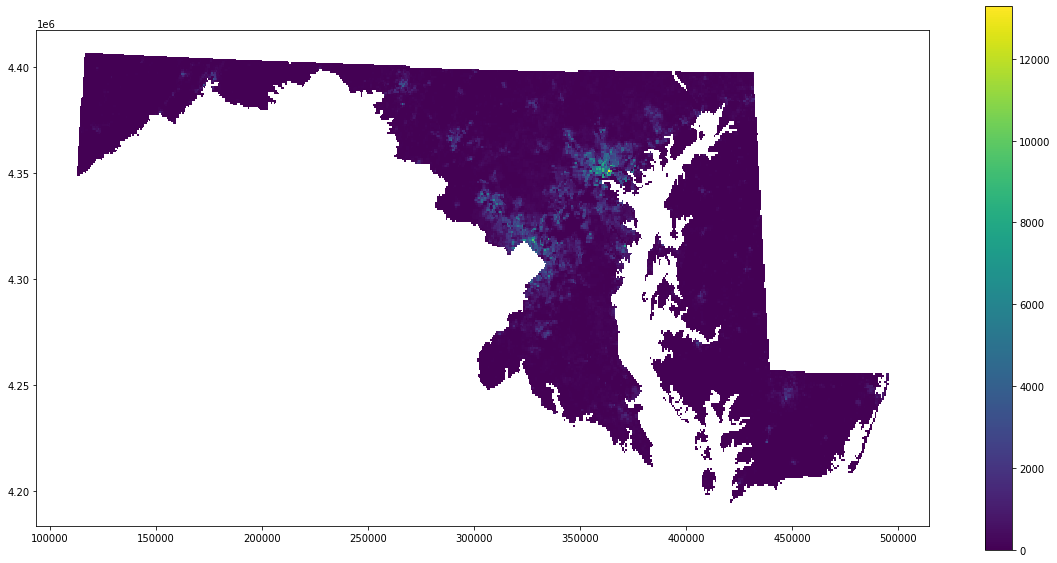

In [7]:
# plot the variables
fig, ax = plt.subplots(figsize=(20,10))
pop.plot('PopDen', legend=True, ax=ax)

<AxesSubplot:>

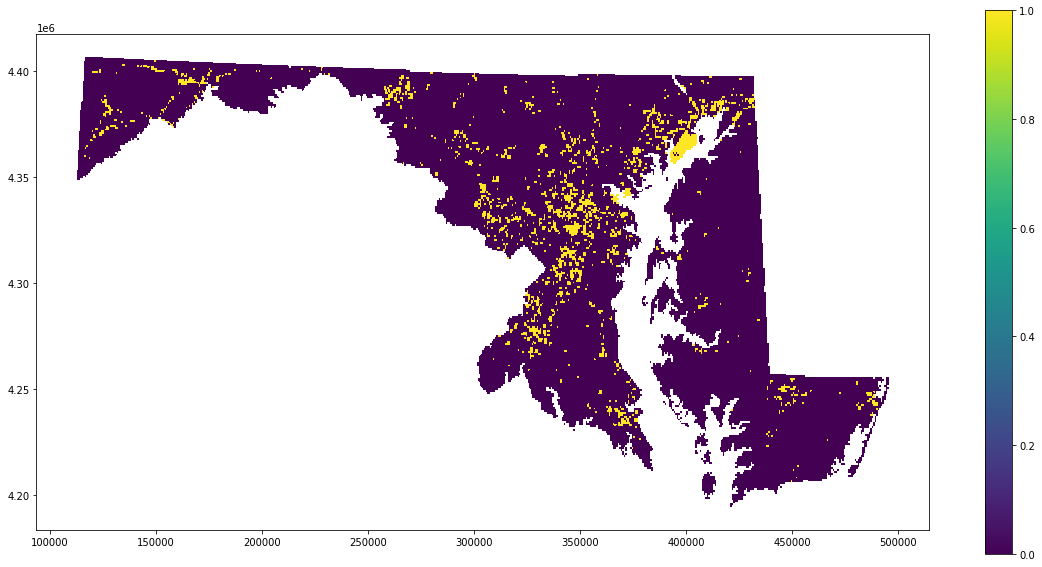

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
pop.plot('ForestLoss', legend=True, ax=ax)

<AxesSubplot:>

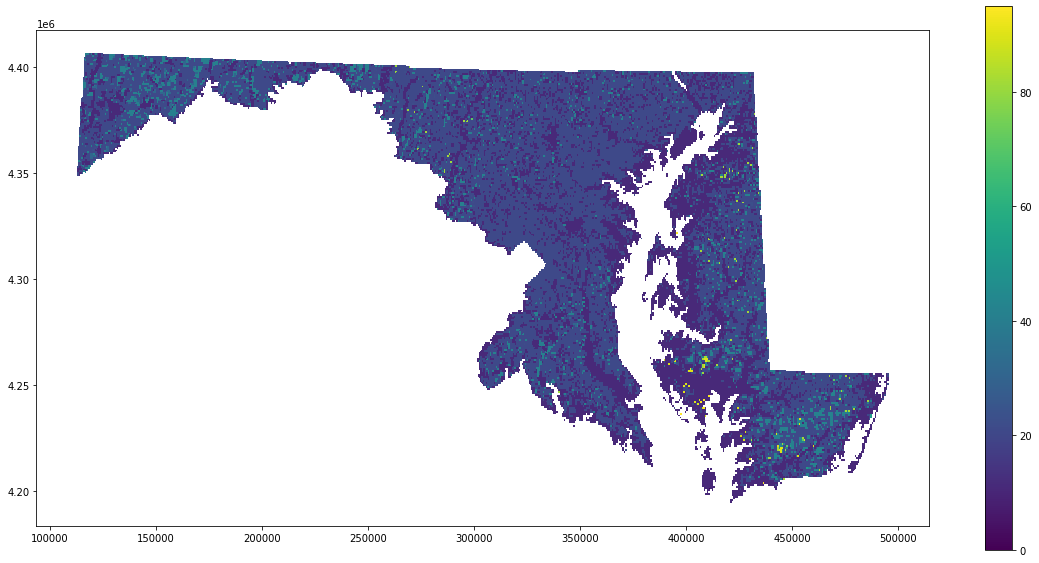

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
pop.plot('LandCover', legend=True, ax=ax)

In [10]:
# Calculate the correlation among the variables
cols = ['PopDen', 'ForestLoss', 'LandCover']
pop[cols].corr()
# No significant correlation found
# Ready to run the regressions

,PopDen,ForestLoss,LandCover
PopDen,1.000000,0.275160,-0.023077
ForestLoss,0.275160,1.000000,-0.057347
LandCover,-0.023077,-0.057347,1.000000


In [11]:
# create Queen spatial weight matrix
w = sw.Queen.from_dataframe(pop)

C:\Users\shenq\Miniconda3\envs\sds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 8 islands with ids: 12032, 18610, 19459, 19630, 35583, 41693, 42696, 42769.
  warnings.warn(message)


In [12]:
# Moran's I for population density
m_popDen = Moran(pop['PopDen'], w)
print(m_popDen.I, m_popDen.p_sim)
# spatial autocorrelation exists

('WARNING: ', 12032, ' is an island (no neighbors)')
('WARNING: ', 18610, ' is an island (no neighbors)')
('WARNING: ', 19459, ' is an island (no neighbors)')
('WARNING: ', 19630, ' is an island (no neighbors)')
('WARNING: ', 35583, ' is an island (no neighbors)')
('WARNING: ', 41693, ' is an island (no neighbors)')
('WARNING: ', 42696, ' is an island (no neighbors)')
('WARNING: ', 42769, ' is an island (no neighbors)')
0.7341429956759339 0.001


In [13]:
# Moran's I for forest loss
m_forestLoss = Moran(pop['ForestLoss'], w)
print(m_forestLoss.I, m_forestLoss.p_sim)
# spatial autocorrelation exists

0.6351525188303357 0.001


In [14]:
# Moran's I for landcover
m_forestLoss = Moran(pop['LandCover'], w)
print(m_forestLoss.I, m_forestLoss.p_sim)
# spatial autocorrelation exists

0.26834039961031136 0.001


In [15]:
# OLS model
# dependent variable: forest loss
# independent variable: population density and landcover

codes = ['PopDen', 'LandCover']

y = pop['ForestLoss'].values.reshape((-1,1))
X = pop[codes].values

# standardize the variables
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean(axis=0)) / y.std(axis=0)

ols_results = spreg.OLS(y, X, w, spat_diag=True, name_x=codes)
print(ols_results.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:       43780
Mean dependent var  :     -0.0000                Number of Variables   :           3
S.D. dependent var  :      1.0000                Degrees of Freedom    :       43777
R-squared           :      0.0783
Adjusted R-squared  :      0.0783
Sum squared residual:   40351.370                F-statistic           :   1859.8517
Sigma-square        :       0.922                Prob(F-statistic)     :           0
S.E. of regression  :       0.960                Log likelihood        :  -60335.961
Sigma-square ML     :       0.922                Akaike info criterion :  120677.923
S.E of regression ML:      0.9600                Schwarz criterion     :  120703.983

-----------------------------------------------------------------------------

<AxesSubplot:>

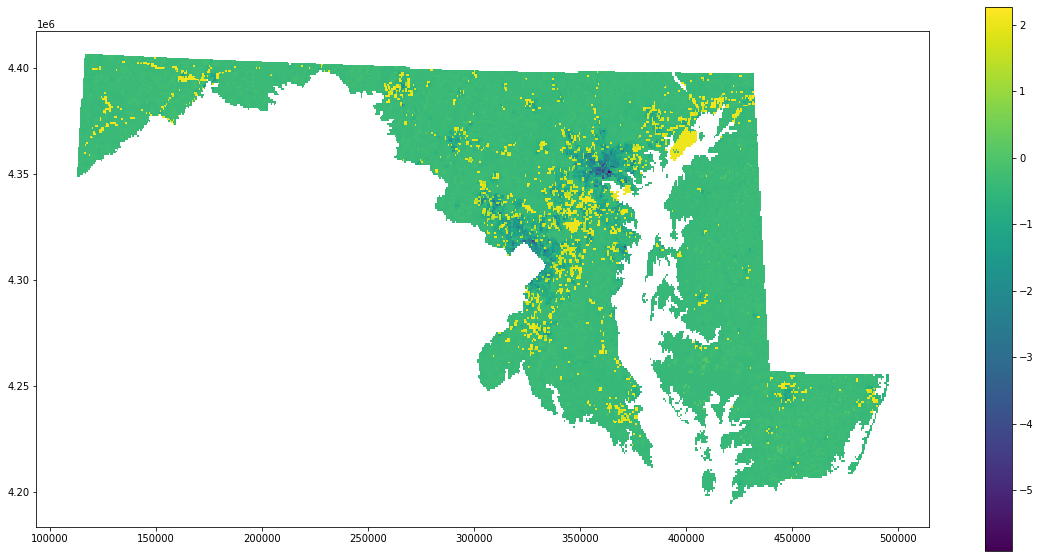

In [16]:
# plot the residuals
pop['ols_resid'] = ols_results.u
fig, ax = plt.subplots(figsize=(20,10))
pop.plot('ols_resid', legend=True, ax=ax)

In [17]:
# compute Moran's I on the residuals
m_ols_resid = Moran(pop['ols_resid'], w)
print(m_ols_resid.I, m_ols_resid.p_sim)
# spatial autocorrelation exists

0.5847766923826122 0.001


In [18]:
# Lag model

lag = spreg.GM_Lag(y, X, w=w, name_x=codes)
print(lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:       43780
Mean dependent var  :     -0.0000                Number of Variables   :           4
S.D. dependent var  :      1.0000                Degrees of Freedom    :       43776
Pseudo R-squared    :      0.6147
Spatial Pseudo R-squared:  0.1177

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.0179782       0.0029955      -6.0018205       0.0000000
              PopDen       0.0332656       0.0053879       6.1741624       0.0000000
           LandCover      -0.0086407       0.0030806      -

In [19]:
# Error model

error = spreg.GM_Error(y, X, w=w, name_x=codes)
print(error.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:       43780
Mean dependent var  :     -0.0000                Number of Variables   :           3
S.D. dependent var  :      1.0000                Degrees of Freedom    :       43777
Pseudo R-squared    :      0.0783

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.0824812       0.0152806      -5.3977751       0.0000001
              PopDen       0.0643341       0.0056668      11.3527256       0.0000000
           LandCover      -0.0105104       0.0034361      -3.0587936       0.0022223
      

In [20]:
# GWR

pop['X'] = pop.apply(lambda row: row.geometry.centroid.coords[0][0], axis=1)
pop['Y'] = pop.apply(lambda row: row.geometry.centroid.coords[0][1], axis=1)
u = pop['X']
v = pop['Y']
coords = list(zip(u,v))

In [19]:
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search(bw_min=1000)
print(gwr_bw)

1001.0


In [20]:
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search(bw_min=500)
print(gwr_bw)

501.0


In [21]:
# As the selector tends to select a local bandwidth, but my data is large, I manually select 1001 as the bandwidth
gwr_model = GWR(coords, y, X, 1001)
gwr_results = gwr_model.fit()

In [22]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                               43780
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          40351.370
Log-likelihood:                                                  -60335.961
AIC:                                                             120677.923
AICc:                                                            120679.924
BIC:                                                            -427490.468
R2:                                                                   0.078
Adj. R2:                                                              0.078

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

Text(0.5, 1.0, 'gwr_LC_tc')

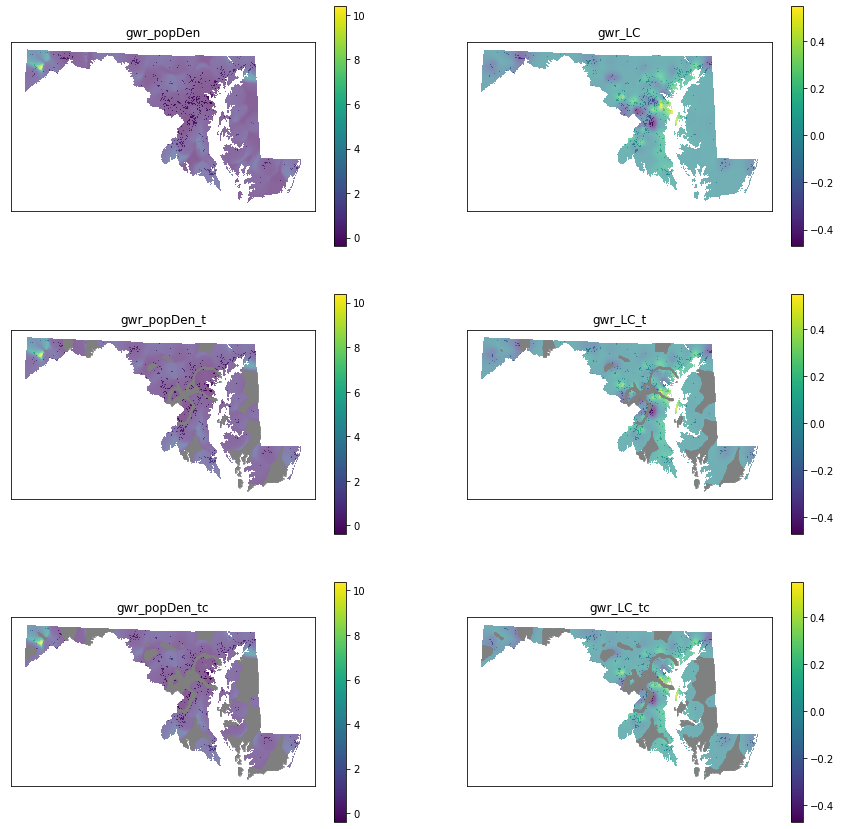

In [34]:
# Save the GWR results
# Plot the GWR results
# Mask statistically insignificant values in grey

filter_tc = gwr_results.filter_tvals() #default behavior using corrected alpha
filter_t = gwr_results.filter_tvals(alpha=0.05) # without correction using common alpha

pop['gwr_popDen'] = gwr_results.params[:,1]
pop['gwr_popDen_t'] = filter_t[:,1]
pop['gwr_popDen_tc'] = filter_tc[:,1]

pop['gwr_LC'] = gwr_results.params[:,2]
pop['gwr_LC_t'] = filter_t[:,2]
pop['gwr_LC_tc'] = filter_tc[:,2]

fig, ax = plt.subplots(3, 2, figsize=(15,15))

pop.plot('gwr_popDen', legend=True, **{'edgecolor':'none', 'alpha':.65, 'linewidth':.5}, ax=ax[0][0])
ax[0][0].get_xaxis().set_visible(False)
ax[0][0].get_yaxis().set_visible(False)
ax[0][0].set_title('gwr_popDen')

pop.plot('gwr_popDen', legend=True, **{'edgecolor':'none', 'alpha':.65, 'linewidth':.5}, ax=ax[1][0])
pop[filter_t[:,1] == 0].plot(color='grey', ax=ax[1][0], **{'edgecolor':'grey','linewidth':.5})    
ax[1][0].get_xaxis().set_visible(False)
ax[1][0].get_yaxis().set_visible(False)
ax[1][0].set_title('gwr_popDen_t')
    
pop.plot('gwr_popDen', legend=True, **{'edgecolor':'none', 'alpha':.65, 'linewidth':.5}, ax=ax[2][0])
pop[filter_tc[:,1] == 0].plot(color='grey', ax=ax[2][0], **{'edgecolor':'grey','linewidth':.5})
ax[2][0].get_xaxis().set_visible(False)
ax[2][0].get_yaxis().set_visible(False)
ax[2][0].set_title('gwr_popDen_tc')


pop.plot('gwr_LC', legend=True, **{'edgecolor':'none', 'alpha':.65, 'linewidth':.5}, ax=ax[0][1])
ax[0][1].get_xaxis().set_visible(False)
ax[0][1].get_yaxis().set_visible(False)
ax[0][1].set_title('gwr_LC')

pop.plot('gwr_LC', legend=True, **{'edgecolor':'none', 'alpha':.65, 'linewidth':.5}, ax=ax[1][1])
pop[filter_t[:,1] == 0].plot(color='grey', ax=ax[1][1], **{'edgecolor':'grey','linewidth':.5})    
ax[1][1].get_xaxis().set_visible(False)
ax[1][1].get_yaxis().set_visible(False)
ax[1][1].set_title('gwr_LC_t')
    
pop.plot('gwr_LC', legend=True, **{'edgecolor':'none', 'alpha':.65, 'linewidth':.5}, ax=ax[2][1])
pop[filter_tc[:,1] == 0].plot(color='grey', ax=ax[2][1], **{'edgecolor':'grey','linewidth':.5})
ax[2][1].get_xaxis().set_visible(False)
ax[2][1].get_yaxis().set_visible(False)
ax[2][1].set_title('gwr_LC_tc')

## I tried MGWR but failed, because my laptop ran out of memory space